In [1]:
!pip install dgl

Defaulting to user installation because normal site-packages is not writeable


In [2]:
from dgl.data.utils import load_graphs
import dgl
import numpy as np
import torch as th
import dgl.nn as dglnn
import dgl.function as fn
import torch.nn as nn
from sklearn.metrics import roc_auc_score
import pickle
from sklearn.preprocessing import LabelEncoder
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')
sns.set_style('darkgrid')

In [3]:
class HeteroDotProductPredictor(nn.Module):
    def forward(self, graph, h, etype):
        with graph.local_scope():
            graph.ndata['h'] = h
            graph.apply_edges(fn.u_dot_v('h', 'h', 'score'), etype=etype)
            return graph.edges[etype].data['score']

In [4]:
def construct_negative_graph(graph, k, etype):
    utype, _, vtype = etype
    src, dst = graph.edges(etype=etype)
    neg_src = src.repeat_interleave(k)
    neg_dst = th.randint(0, graph.num_nodes(vtype), (len(src) * k,))
    return dgl.heterograph(
        {etype: (neg_src, neg_dst)},
        num_nodes_dict={ntype: graph.num_nodes(ntype) for ntype in graph.ntypes})

In [5]:
def compute_loss(pos_score, neg_score):
    n_edges = pos_score.shape[0]
    return (1 - pos_score + neg_score.view(n_edges, -1)).clamp(min=0).mean()

def compute_auc(pos_score, neg_score):
    scores = th.cat([pos_score, neg_score]).numpy()
    labels = th.cat(
        [th.ones(pos_score.shape[0]), th.zeros(neg_score.shape[0])]
    ).numpy()
    return roc_auc_score(labels, scores)

In [6]:
class RGCN3(nn.Module):
    def __init__(self, in_feats, hid_feats, out_feats, rel_names):
        super().__init__()
        self.conv1 = dglnn.HeteroGraphConv({
            rel: dglnn.GATConv(in_feats, hid_feats, num_heads=3)
            for rel in rel_names}, aggregate='sum')
        self.conv2 = dglnn.HeteroGraphConv({
            rel: dglnn.GATConv(hid_feats, out_feats, num_heads=3)
            for rel in rel_names}, aggregate='sum')
        self.fc = nn.Linear(in_features=772, out_features=768)

    def forward(self, graph, inputs):
        inputs_current = inputs.copy()
        inputs_current['company'] = self.fc(inputs_current['company'])
        h = self.conv1(graph, inputs_current)
        h = {k: v.relu() for k, v in h.items()}
        h = self.conv2(graph, h)
        return h

In [7]:
class Model3(nn.Module):
    def __init__(self, in_features, hidden_features, out_features, rel_names):
        super().__init__()
        self.sage = RGCN3(in_features, hidden_features, out_features, rel_names)
        self.pred = HeteroDotProductPredictor()
    def forward(self, g, neg_g, x, etype):
        h = self.sage(g, x)
        return self.pred(g, h, etype), self.pred(neg_g, h, etype)

In [8]:
model = th.load('model3')

In [9]:
model

Model3(
  (sage): RGCN3(
    (conv1): HeteroGraphConv(
      (mods): ModuleDict(
        (dop_okved): GATConv(
          (fc): Linear(in_features=768, out_features=150, bias=False)
          (feat_drop): Dropout(p=0.0, inplace=False)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (leaky_relu): LeakyReLU(negative_slope=0.2)
        )
        (main_okved): GATConv(
          (fc): Linear(in_features=768, out_features=150, bias=False)
          (feat_drop): Dropout(p=0.0, inplace=False)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (leaky_relu): LeakyReLU(negative_slope=0.2)
        )
        (dop_okved_for): GATConv(
          (fc): Linear(in_features=768, out_features=150, bias=False)
          (feat_drop): Dropout(p=0.0, inplace=False)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (leaky_relu): LeakyReLU(negative_slope=0.2)
        )
        (parent): GATConv(
          (fc): Linear(in_features=768, out_features=150, bias=False)
       

In [10]:
G = load_graphs('Graph.bin')
G = G[0][0]
G

Graph(num_nodes={'company': 1485, 'okved': 1491},
      num_edges={('company', 'dop_okved', 'okved'): 31667, ('company', 'main_okved', 'okved'): 1485, ('okved', 'dop_okved_for', 'company'): 31667, ('okved', 'parent', 'okved'): 1407},
      metagraph=[('company', 'okved', 'dop_okved'), ('company', 'okved', 'main_okved'), ('okved', 'company', 'dop_okved_for'), ('okved', 'okved', 'parent')])

In [11]:
columns = ['is_social', 'licenses', 'workers', 'category']
dop = G.nodes['company'].data['address']

for v in columns:
    dop = th.hstack((dop, G.nodes['company'].data[v].reshape(-1, 1)))

company_feats = dop.float()
okved_feats = G.nodes['okved'].data['embeddings'].float()

node_features = {'company': company_feats, 'okved': okved_feats}

In [12]:
k = 5
negative_graph = construct_negative_graph(G, k, ('company', 'dop_okved', 'okved'))
pos_score, neg_score = model(G, negative_graph, node_features, ('company', 'dop_okved', 'okved'))

In [13]:
probabilities_edges = th.sigmoid(pos_score.mean(dim=[1, 2]).view(1,-1)[0])
probabilities_edges

tensor([0.9999, 0.9999, 0.9998,  ..., 0.9998, 0.9995, 0.9998],
       grad_fn=<SigmoidBackward0>)

In [14]:
company_node, edge_node = G.edges(etype='dop_okved')
triples = []

for i in range(len(company_node)):
    triples.append([company_node[i].item(), edge_node[i].item(), probabilities_edges[i].item()])

In [15]:
triples[:10], triples[-10:]

([[0, 11, 0.9998515844345093],
  [0, 12, 0.9999204874038696],
  [0, 18, 0.9997662901878357],
  [0, 19, 0.9998847246170044],
  [0, 28, 0.9998675584793091],
  [0, 37, 0.9998447895050049],
  [0, 47, 0.9997327923774719],
  [0, 56, 0.9997658133506775],
  [0, 58, 0.9998093247413635],
  [0, 64, 0.999686598777771]],
 [[1460, 1395, 0.9887012243270874],
  [1460, 1396, 0.9770646095275879],
  [1460, 1397, 0.9448118209838867],
  [1460, 1399, 0.9565364122390747],
  [1460, 1453, 0.9894459843635559],
  [1460, 1481, 0.9910768270492554],
  [1482, 1406, 0.9997838139533997],
  [1482, 1410, 0.9997708201408386],
  [1482, 1415, 0.9994997978210449],
  [1482, 1416, 0.9997901320457458]])

In [16]:
dop_dict = {}
edges_full = np.array([[-1000, -1000]])

for i in range(len(triples) - 1):
    if i != len(triples) - 2:
        if triples[i][0] == triples[i + 1][0]:
            dop_dict[(triples[i][0], triples[i][1])] = triples[i][2]
        else:
            dop_dict[(triples[i][0], triples[i][1])] = triples[i][2]
            idx_max_score = np.array(list(dop_dict.values())).argsort()[-5:]
            edges_with_max_score = np.array(list(dop_dict.keys()))[idx_max_score, :]
            edges_full = np.vstack((edges_full, edges_with_max_score))
            dop_dict = {}
    else:
        dop_dict[(triples[i][0], triples[i][1])] = triples[i][2]
        dop_dict[(triples[i + 1][0], triples[i + 1][1])] = triples[i + 1][2]
        idx_max_score = np.array(list(dop_dict.values())).argsort()[-5:]
        edges_with_max_score = np.array(list(dop_dict.keys()))[idx_max_score, :]
        edges_full = np.vstack((edges_full, edges_with_max_score))

edges_full = edges_full[1:]

In [17]:
edges_full[:10], edges_full[-10:] 

(array([[  0,  73],
        [  0,  28],
        [  0,  19],
        [  0, 103],
        [  0,  12],
        [  1,  58],
        [  1,   2],
        [  1, 103],
        [  1,  46],
        [  1,  78]]),
 array([[1457, 1405],
        [1460, 1088],
        [1460,  862],
        [1460, 1093],
        [1460, 1102],
        [1460, 1108],
        [1482, 1415],
        [1482, 1410],
        [1482, 1406],
        [1482, 1416]]))

In [18]:
print(f'Кол-во связей: {len(edges_full)}\nКол-во уникальных доп. оквэдов: {np.unique(edges_full[:, 1]).__len__()}\n\
Кол-во компаний, у которых есть доп. оквэд: {np.unique(edges_full[:, 0]).__len__()}')

Кол-во связей: 7023
Кол-во уникальных доп. оквэдов: 446
Кол-во компаний, у которых есть доп. оквэд: 1472


In [19]:
le_company = pickle.load(open('le_company.sav', 'rb'))
le_okved = pickle.load(open('le_okved.sav', 'rb'))

In [20]:
company = le_company.inverse_transform(edges_full[:, 0])
company

array(['АКЦИОНЕРНОЕ ОБЩЕСТВО "50 ЛЕТ ОКТЯБРЯ"0',
       'АКЦИОНЕРНОЕ ОБЩЕСТВО "50 ЛЕТ ОКТЯБРЯ"0',
       'АКЦИОНЕРНОЕ ОБЩЕСТВО "50 ЛЕТ ОКТЯБРЯ"0', ...,
       'СТОМАТОЛОГИЧЕСКАЯ КЛИНИКА " ВИЗИТ " ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ1484',
       'СТОМАТОЛОГИЧЕСКАЯ КЛИНИКА " ВИЗИТ " ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ1484',
       'СТОМАТОЛОГИЧЕСКАЯ КЛИНИКА " ВИЗИТ " ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ1484'],
      dtype=object)

In [21]:
dop_okved = le_okved.inverse_transform(edges_full[:, 1])
dop_okved

array(['01.46', '01.13.51', '01.13.1', ..., '86.23', '86.21', '86.90.9'],
      dtype=object)

In [342]:
G = nx.DiGraph()
G.add_edges_from(zip(company, dop_okved))

In [343]:
count_company = 0
count_okved = 0

for i in G.nodes:
    if i in company:
        G.nodes[i]['type'] = 'company'
        G.nodes[i]['color'] = count_company
        G.nodes[i]['position'] = [0, count_company]
        count_company += 1
    else:
        G.nodes[i]['type'] = 'okved'
        G.nodes[i]['color'] = count_okved
        G.nodes[i]['position'] = [100, count_okved * 3.5]
        count_okved += 1

In [346]:
node_colors = [G.nodes[node]['color'] for node in G.nodes]
node_size = [1 if G.nodes[node]['type'] == 'company' else 10 for node in G.nodes]
edge_colors = [G.nodes[edge[0]]['color'] for edge in G.edges]
pos = {node : G.nodes[node]['position'] for node in G.nodes}

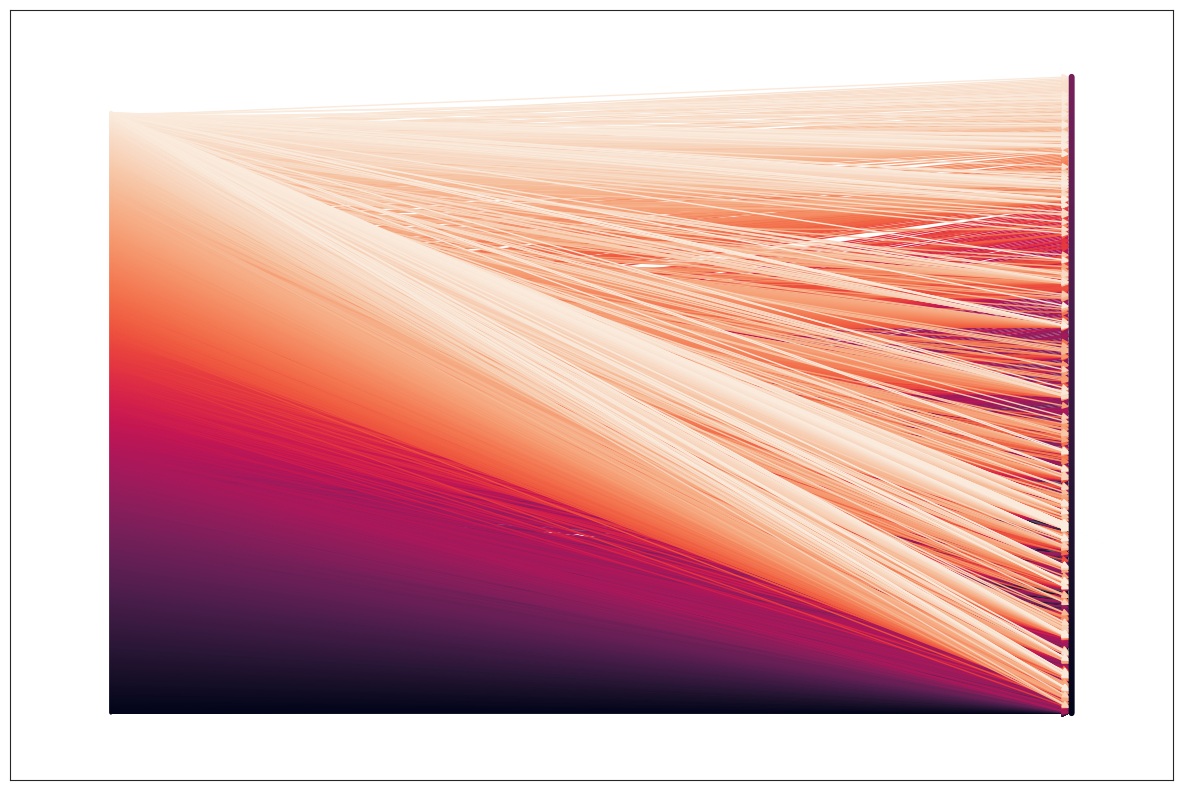

In [347]:
sns.set_style('white')
plt.figure(figsize=(15, 10))
nx.draw_networkx(G, pos=pos, node_size=node_size, node_color=node_colors, edge_color=edge_colors, with_labels=False)

In [348]:
nx.write_gpickle(G, "G_final.gpickle")

In [377]:
G = nx.read_gpickle("G_final.gpickle")

In [378]:
random_company = np.random.choice(np.unique(company), 5, replace=False)
new_edges = []

for edge in G.edges:
    if edge[0] in random_company:
        new_edges.append(edge)

In [379]:
G_new = nx.DiGraph()
G_new.add_edges_from(new_edges)

In [380]:
count_company = 0
count_okved = 0
pos = {}

for i in G_new.nodes:
    if i in company:
        count_company += 1
    else:
        count_okved += 1
        
y_company = np.linspace(0, 100, count_company)
y_okved = np.linspace(0, 100, count_okved)

i = 0
j = 0

for node in G_new.nodes:
    if node in company:
        pos[node] = [0, y_company[i]]
        i += 1
    else:
        pos[node] = [100, y_okved[j]]
        j += 1

In [381]:
node_colors = [G.nodes[node]['color'] for node in G_new.nodes]
node_size = [25 if G.nodes[node]['type'] == 'company' else 5 for node in G_new.nodes]
edge_colors = [G.nodes[edge[0]]['color'] for edge in G_new.edges]

In [382]:
new_labels = []

for label in list(G_new.nodes):
    if len(label) > 8:
        new_labels.append(label.split('"')[-2])
    else:
        new_labels.append(label)

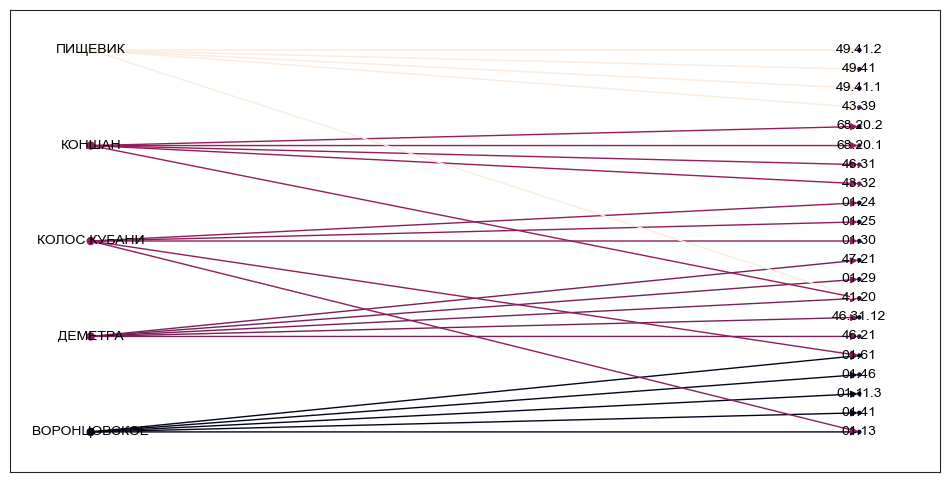

In [383]:
sns.set_style('white')
plt.figure(figsize=(12, 6))
nx.draw_networkx(G_new, pos=pos, node_size=node_size, node_color=node_colors ,edge_color=edge_colors, 
                 with_labels=True, font_size = 10, labels=dict(zip(list(G_new.nodes), new_labels)))

In [22]:
data = pd.DataFrame(np.hstack((company.reshape(-1, 1), dop_okved.reshape(-1, 1)))).rename(columns={0 : 'Компания', 1 : 'Дополнительный ОКВЭД'})
data

,Компания,Дополнительный ОКВЭД
0,"АКЦИОНЕРНОЕ ОБЩЕСТВО ""50 ЛЕТ ОКТЯБРЯ""0",01.46
1,"АКЦИОНЕРНОЕ ОБЩЕСТВО ""50 ЛЕТ ОКТЯБРЯ""0",01.13.51
2,"АКЦИОНЕРНОЕ ОБЩЕСТВО ""50 ЛЕТ ОКТЯБРЯ""0",01.13.1
3,"АКЦИОНЕРНОЕ ОБЩЕСТВО ""50 ЛЕТ ОКТЯБРЯ""0",01.61
4,"АКЦИОНЕРНОЕ ОБЩЕСТВО ""50 ЛЕТ ОКТЯБРЯ""0",01.11.3
...,...,...
7018,"САНАТОРИЙ "" ВИТА "" ( ОБЩЕСТВО С ОГРАНИЧЕННОЙ О...",56.30
7019,"СТОМАТОЛОГИЧЕСКАЯ КЛИНИКА "" ВИЗИТ "" ОБЩЕСТВО С...",86.90.4
7020,"СТОМАТОЛОГИЧЕСКАЯ КЛИНИКА "" ВИЗИТ "" ОБЩЕСТВО С...",86.23
7021,"СТОМАТОЛОГИЧЕСКАЯ КЛИНИКА "" ВИЗИТ "" ОБЩЕСТВО С...",86.21


In [23]:
data_for_klasters = pd.pivot_table(data, index = 'Компания', columns = 'Дополнительный ОКВЭД',
               values = 'Дополнительный ОКВЭД', fill_value=0, aggfunc={'Дополнительный ОКВЭД':'count'})
data_for_klasters.head()

Дополнительный ОКВЭД,01.1,01.11,01.11.1,01.11.2,01.11.3,01.12,01.13,01.13.1,01.13.12,01.13.3,...,91.03,93.11,93.19,93.29,93.29.9,95.22.1,96.02,96.02.2,96.04,96.09
Компания,,,,,,,,,,,,,,,,,,,,,
"АКЦИОНЕРНОЕ ОБЩЕСТВО ""50 ЛЕТ ОКТЯБРЯ""0",0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
"АКЦИОНЕРНОЕ ОБЩЕСТВО ""АГРОНОВА""1",0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"АКЦИОНЕРНОЕ ОБЩЕСТВО ""АГРОПРОМЫШЛЕННАЯ КОМПАНИЯ ""МИХАЙЛОВСКИЙ ПЕРЕВАЛ""2",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"АКЦИОНЕРНОЕ ОБЩЕСТВО ""АГРОФИРМА КУХАРИВСКАЯ""3",0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"АКЦИОНЕРНОЕ ОБЩЕСТВО ""АРМАВИРСКИЙ ХЛЕБОПРОДУКТ""407",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [42]:
kmeans = KMeans(n_clusters=6, n_init=20).fit(data_for_klasters)
data_for_klasters['Кластер'] = kmeans.labels_
data_for_klasters.head()

Дополнительный ОКВЭД,01.1,01.11,01.11.1,01.11.2,01.11.3,01.12,01.13,01.13.1,01.13.12,01.13.3,...,93.11,93.19,93.29,93.29.9,95.22.1,96.02,96.02.2,96.04,96.09,Кластер
Компания,,,,,,,,,,,,,,,,,,,,,
"АКЦИОНЕРНОЕ ОБЩЕСТВО ""50 ЛЕТ ОКТЯБРЯ""0",0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,4
"АКЦИОНЕРНОЕ ОБЩЕСТВО ""АГРОНОВА""1",0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
"АКЦИОНЕРНОЕ ОБЩЕСТВО ""АГРОПРОМЫШЛЕННАЯ КОМПАНИЯ ""МИХАЙЛОВСКИЙ ПЕРЕВАЛ""2",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
"АКЦИОНЕРНОЕ ОБЩЕСТВО ""АГРОФИРМА КУХАРИВСКАЯ""3",0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
"АКЦИОНЕРНОЕ ОБЩЕСТВО ""АРМАВИРСКИЙ ХЛЕБОПРОДУКТ""407",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3


In [43]:
data_for_klasters['Кластер'].value_counts()

3    575
5    250
4    216
1    177
0    164
2     90
Name: Кластер, dtype: int64

In [46]:
coords = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(data_for_klasters.iloc[:, ])
coords

array([[-88.08036 ,  -6.278396],
       [-51.90454 ,  24.12145 ],
       [-13.517524,  39.08831 ],
       ...,
       [ 23.898767, -44.86964 ],
       [ 73.56973 ,  -8.230108],
       [ -1.187509,  74.89212 ]], dtype=float32)

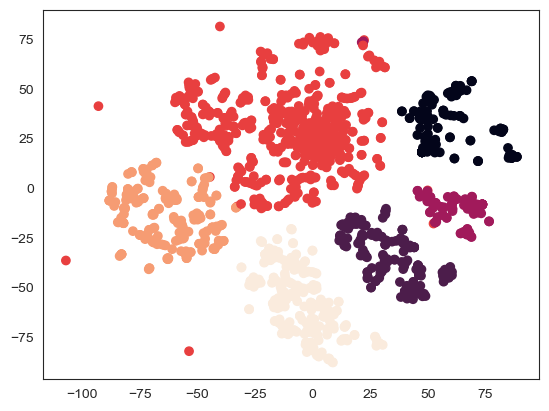

In [47]:
sns.set_style('white')
plt.scatter(coords[:, 0], coords[:, 1], c=data_for_klasters.iloc[:, -1].values)
plt.show()

In [56]:
data = pd.read_excel('Датасет_idx.xlsx', index_col=1)
data = data.drop(columns='Unnamed: 0')
data.head()

,Категория,ОГРН,ИНН,Основной вид деятельности,Дополнительный вид деятельности,Дополнительный вид деятельности (расшифровка),Дата включения в реестр,Наличие лицензий,Является социальным предприятием,Среднесписочная численность работников за предшествующий календарный год,Адрес
Наименование / ФИО,,,,,,,,,,,
"АКЦИОНЕРНОЕ ОБЩЕСТВО ""50 ЛЕТ ОКТЯБРЯ""0",1,1112361001103,2361007110,01.11.1 Выращивание зерновых культур,"['01.11.2', '01.11.3', '01.13', '01.13.1', '01...","['Выращивание зернобобовых культур', 'Выращива...",10.08.2017,1,0,95,"Щербиновский р-н, , с Николаевка"
"АКЦИОНЕРНОЕ ОБЩЕСТВО ""АГРОНОВА""1",0,1167847206450,7838053444,01.50 Смешанное сельское хозяйство,"['01.11', '01.13', '01.13.1', '01.19', '01.24'...","['Выращивание зерновых (кроме риса), зернобобо...",10.08.2017,1,0,93,"Лабинский р-н, г Лабинск,"
"АКЦИОНЕРНОЕ ОБЩЕСТВО ""АГРОПРОМЫШЛЕННАЯ КОМПАНИЯ ""МИХАЙЛОВСКИЙ ПЕРЕВАЛ""2",0,1022300768555,2304036179,01.2 Выращивание многолетних культур,"['01.21', '01.25', '01.61', '02.10', '02.20', ...","['Выращивание винограда', 'Выращивание прочих ...",10.08.2017,1,0,56,", г Геленджик, с Пшада"
"АКЦИОНЕРНОЕ ОБЩЕСТВО ""АГРОФИРМА КУХАРИВСКАЯ""3",1,1022303857003,2331012177,01.41.11 Разведение молочного крупного рогатог...,"['01.11.1', '01.11.2', '01.11.3', '01.13.3', '...","['Выращивание зерновых культур', 'Выращивание ...",10.07.2023,1,0,165,"Ейский р-н, , с Кухаривка"
"АКЦИОНЕРНОЕ ОБЩЕСТВО ""БЕЛАГРО""4",1,1042301302713,2303022021,01.50 Смешанное сельское хозяйство,"['01.11', '01.13', '01.2', '01.25', '01.30', '...","['Выращивание зерновых (кроме риса), зернобобо...",10.08.2019,0,0,112,"Белореченский р-н, , с Школьное"


In [62]:
data.loc[data_for_klasters[data_for_klasters['Кластер'] == 0].index, :]['Основной вид деятельности'].value_counts()

41.20 Строительство жилых и нежилых зданий                                                                                               147
41.2 Строительство жилых и нежилых зданий                                                                                                  9
86.90.4 Деятельность санаторно-курортных организаций                                                                                       3
56.10 Деятельность ресторанов и услуги по доставке продуктов питания                                                                       2
86.90.9 Деятельность в области медицины прочая, не включенная в другие группировки                                                         1
56.29.2 Деятельность столовых и буфетов при предприятиях и учреждениях                                                                     1
56.10.1 Деятельность ресторанов и кафе с полным ресторанным обслуживанием, кафетериев, ресторанов быстрого питания и самообслуживания      1
Name: Основно

In [63]:
data.loc[data_for_klasters[data_for_klasters['Кластер'] == 1].index, :]['Основной вид деятельности'].value_counts()

86.10 Деятельность больничных организаций                                                  51
86.21 Общая врачебная практика                                                             43
86.23 Стоматологическая практика                                                           43
86 Деятельность в области здравоохранения                                                  15
86.90.4 Деятельность санаторно-курортных организаций                                        9
86.90.9 Деятельность в области медицины прочая, не включенная в другие группировки          9
01.11 Выращивание зерновых (кроме риса), зернобобовых культур и семян масличных культур     1
86.22.1 Деятельность в области косметологии                                                 1
01.43.1 Разведение лошадей, ослов, мулов, лошаков                                           1
10.51 Производство молока (кроме сырого) и молочной продукции                               1
86.90 Деятельность в области медицины прочая                

In [64]:
data.loc[data_for_klasters[data_for_klasters['Кластер'] == 2].index, :]['Основной вид деятельности'].value_counts()

41.20 Строительство жилых и нежилых зданий              74
41.2 Строительство жилых и нежилых зданий               14
01.61 Предоставление услуг в области растениеводства     1
86.10 Деятельность больничных организаций                1
Name: Основной вид деятельности, dtype: int64

In [77]:
data.loc[data_for_klasters[data_for_klasters['Кластер'] == 3].index, :]['Основной вид деятельности'].value_counts()

41.20 Строительство жилых и нежилых зданий                                                          54
01.11 Выращивание зерновых (кроме риса), зернобобовых культур и семян масличных культур             44
01.11.1 Выращивание зерновых культур                                                                39
10.71 Производство хлеба и мучных кондитерских изделий, тортов и пирожных недлительного хранения    33
56.10 Деятельность ресторанов и услуги по доставке продуктов питания                                32
                                                                                                    ..
10.5 Производство молочной продукции                                                                 1
10.89.8 Производство биологически активных добавок к пище                                            1
10.8 Производство прочих пищевых продуктов                                                           1
10.9 Производство готовых кормов для животных                            

In [66]:
data.loc[data_for_klasters[data_for_klasters['Кластер'] == 4].index, :]['Основной вид деятельности'].value_counts()

01.11.1 Выращивание зерновых культур                                                                                                   139
01.11 Выращивание зерновых (кроме риса), зернобобовых культур и семян масличных культур                                                 22
01.1 Выращивание однолетних культур                                                                                                     11
01.25.1 Выращивание прочих плодовых и ягодных культур                                                                                    6
01.46 Разведение свиней                                                                                                                  5
01.21 Выращивание винограда                                                                                                              5
01.12 Выращивание риса                                                                                                                   4
10.41 Производство масел и 

In [67]:
data.loc[data_for_klasters[data_for_klasters['Кластер'] == 5].index, :]['Основной вид деятельности'].value_counts()

56.10 Деятельность ресторанов и услуги по доставке продуктов питания                                                                     169
86.90.4 Деятельность санаторно-курортных организаций                                                                                      22
56.29 Деятельность предприятий общественного питания по прочим видам организации питания                                                  15
10.71 Производство хлеба и мучных кондитерских изделий, тортов и пирожных недлительного хранения                                           9
56.10.1 Деятельность ресторанов и кафе с полным ресторанным обслуживанием, кафетериев, ресторанов быстрого питания и самообслуживания      7
56.1 Деятельность ресторанов и услуги по доставке продуктов питания                                                                        4
86.21 Общая врачебная практика                                                                                                             3
10.41 Произво